# Policy Robustness and Policy Selection

Within this notebook we analyse robustness of policies found with directed search and further constrained according to acceptability criteria of the client. This allows for investigating robustness trade-offs as well as selecting the most robust policies. Our final choice of recommended policies is also informed by a preference for keeping a diverse set of policies in terms of the levers included.

#### Robustness metrics
There exists a multitude of robustness metric, stemming from the fact that there is no single definition of robustness (McPhail et al., 2018). Thus, we will analyze the policies using two commonly used metrics, each having a different focus.

The first metric used is the *signal to noise ratio (SNR)*, an expected value robustness metric. *Signal to noise ratio* indicates an expected level of performance across a range of scenarios. In our case, we desire low values due to our minimization objective for all outcomes. Therefore, it calculated as a product of mean and standard deviation of the outcome value across all scenarios.

Secondly, we use *maximum regret*, which is as the name suggests a regret-based metric. *Regret* of a policy is defined as the difference between the performance (outcome value) of the selected policy for a particular scenario and the performance of the best possible policy for that scenario. Maximum regret is calculated per policy, per outcome across all scenarios.

The first metric is used to see the general performance of our candidate solutions, while maximum regret is used to see what happens in worst-case scenarios. These metrics, combined with qualitative and political considerations, form the basis on which the final set of recommended policies is created.

#### Approach to analysis and policy selection

We do the following to **explore** the candidate policy solution space and **select robust** policies:

1. calculate SNR score, plot all candidate policies by snr robustness scores, grouped by origin scenario as well as plot candidate policies individually per origin scenario. Comment on the results. We then **reduce** the candidate space by filtering out the worst 50% of performers in terms of *A4 Expected Annual Damage* SNR score and comment on the remaining policies.

2. calculate Maximum Regret for remaining policies and plot heatmaps and pairplots per scenario. Comment on the results.

3. Final selection comprising of:
- taking out 9 solutions that are irrelevant or otherwise clearly dominated.
- plotting SNR and recalculated Maximum Regret
- selecting 4 diverse and robust solutions based on SNR Maximum Regret (absolute best perfomers overall, solutions that make use of alternative levers or that make trade-offs elsewhere)
- plotting SNR and recalculated Maximum Regret

-------------------
## 0. Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import pareto
from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    ScalarOutcome,
    load_results
)

from ema_workbench.analysis import parcoords
from ema_workbench.util import ema_logging

As input to this analysis we take results of performing experiments for the 50 policies coming from directed search across 1000 scenarios which were conducted with *run_robustness_experiments.py* script. 

In [2]:
robustness_results = load_results('./output/robustness_experiment_results.tar.gz')
experiments, outcomes = robustness_results

Next we separate experiment results according to which of the four Scenarios passed to directed search and which Policy they was originally generated for, such that we can group the results by scenario.

In [3]:
# Add a column informing of original scenario
experiments['Original Scenario'] = ''
for idx, row in experiments.iterrows():
    experiments.at[idx, 'Original Scenario'] = row.policy.split('_')[0][1:]

In [4]:
# Create two dictionaries separating entries by scenarios
experiments_by_scenario = {}
outcomes_by_scenario = {}
scenarios = np.unique(experiments['Original Scenario'])

for scenario in scenarios:
    experiments_by_scenario[scenario] = experiments[experiments['Original Scenario'] == scenario]

    indices = list(experiments_by_scenario[scenario].index)

    outcomes_by_scenario[scenario] = {}
    for key, array in outcomes.items():
        outcomes_by_scenario[scenario][key] = []

        for i in indices:
            outcomes_by_scenario[scenario][key].append(array[i])

----------

## 1. Signal to Noise Ratio (SNR)

### Calculations

In [5]:
# Function to calculate SNR metric
def snr(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MINIMIZE:
        return mean*std
    else:
        return mean/std

In [6]:
# Define variables relevant for correct handling of policy filtering
model, steps = get_model_for_problem_formulation('A4 Only')
outcomes_of_interest = ['A4_Expected_Annual_Damage', 'A4_Expected_Number_of_Deaths',
                        'Total_Expected_Annual_Damage', 'Total_Expected_Number_of_Deaths',
                        'Total_Infrastructure_Costs']

In [7]:
# Calculate SNR scores per policy per outcome and write it to a dictionary organized by scenario
snr_scores = {}
for scenario in scenarios:
    experiment_snr_scores = {}
    for policy in experiments_by_scenario[scenario]['policy']:
        scores = {}
        
        logical = experiments['policy']==policy
        
        for outcome in model.outcomes:
            value  = outcomes[outcome.name][logical]
            sn_ratio = snr(value, outcome.kind)
            scores[outcome.name] = sn_ratio
        experiment_snr_scores[policy] = scores
    df = pd.DataFrame.from_dict(experiment_snr_scores).T
    snr_scores[scenario] = df

In [8]:
snr_scores['91325'].head()

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
s91325_p100,3.287462e+11,1.362695e-09,5.027419,4.363550e+17,0.004644
s91325_p87,1.346698e+13,3.584817e-08,0.652130,1.801843e+18,0.027197
s91325_p60,4.162015e+13,1.126817e-07,0.315831,1.656078e+18,0.026342
s91325_p66,6.879480e+12,1.841354e-08,0.000000,1.768064e+18,0.019759
s91325_p48,3.358941e+12,1.040087e-08,3.566111,9.522068e+17,0.016614


It may be surprising to see that SNR score for *Total Infrastructure costs* are close to zero or equal to zero in many cases. As we investigated, this is related to very low (or zero) values of standard deviation of *Total Infrastructure costs*.

### Visualisations

First we determine the limits of the line plots, such that they are kept contant across scenarios.

In [9]:
# Determine min and max values for plotting
limits = parcoords.get_limits(snr_scores[scenarios[0]])
limits.loc[0, outcomes_of_interest]=0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = pd.concat(snr_scores)[outcome].max()

limits

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
0,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
1,7.154821e+14,0.000002,14.679912,2.013291e+18,0.028447


Next, we plot all candidate policies by SNR robustness scores, color-grouped by origin scenario.

In [10]:
original_scenarios = experiments['Original Scenario'].unique().tolist()
original_scenarios.sort()

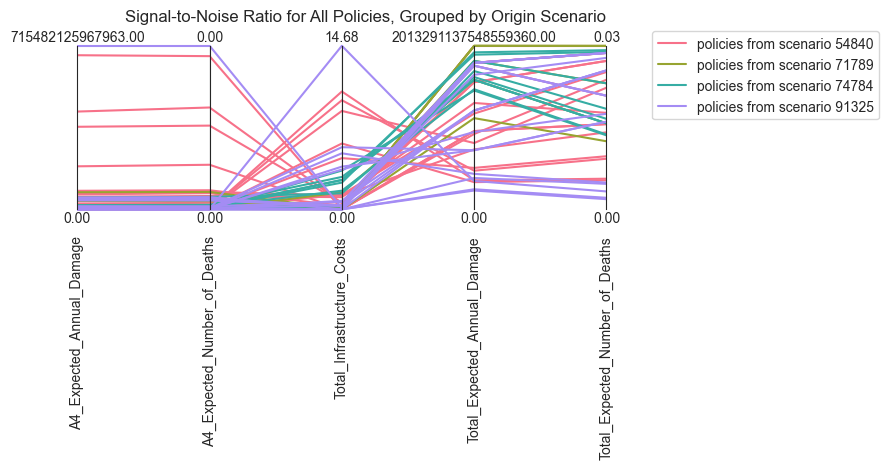

In [11]:
colors = sns.color_palette("husl", len(scenarios))
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for count, scenario in enumerate(scenarios):

    data = snr_scores[scenario]
    paraxes.plot(data, color=colors[count], label='policies from scenario ' + original_scenarios[count])
        
    plt.title(f'Signal-to-Noise Ratio for All Policies, Grouped by Origin Scenario', loc='right')
    plt.savefig('img/snr__all_grouped_pairplot.png')
    
paraxes.legend()

The diagram is hard to read due to the violet lines on top overlying lines of previously drawn scenarios. Interestingly policies from scenarios s71789 and s74784 tend to have low SNR for A4 outcomes as well as *Total Infrastructure Costs*.

Next, we plot SNR of candidate policies individually per origin scenario, for easier visual inspection and to compare differences between the policies based on their origin scenario.

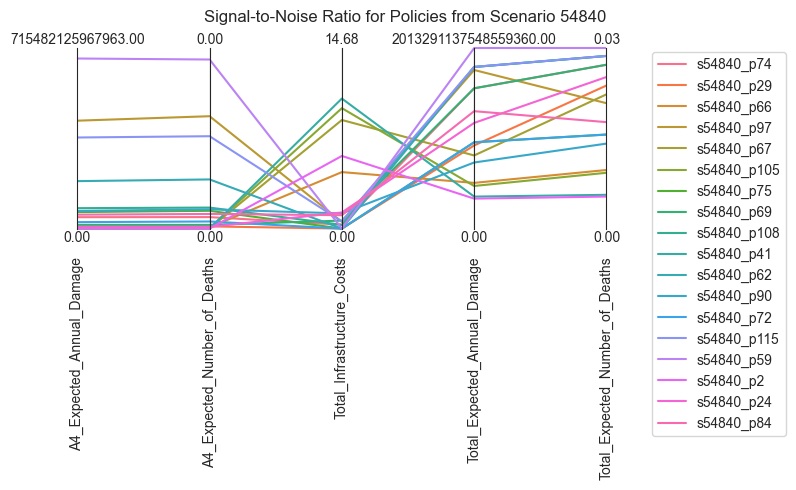

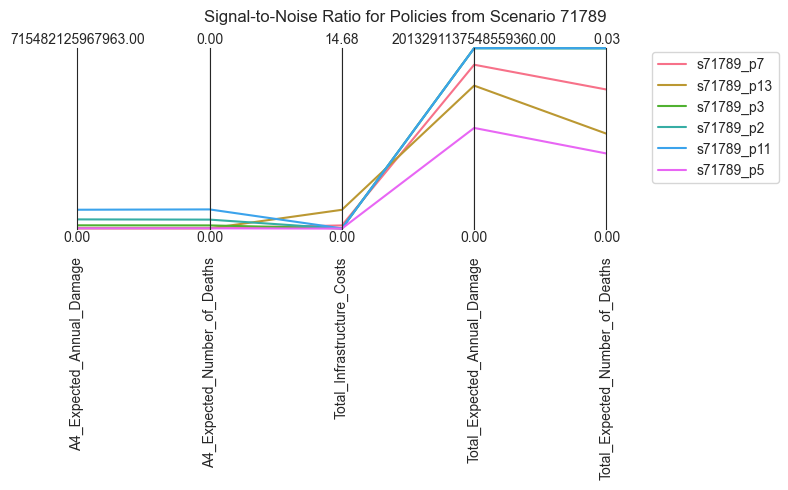

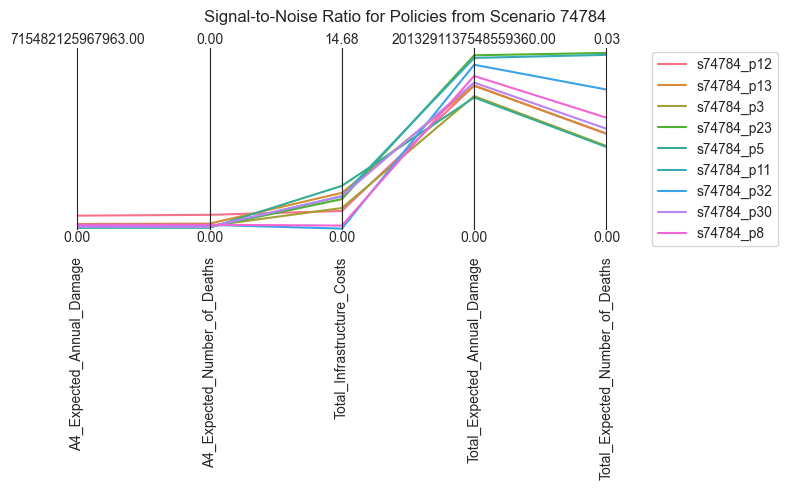

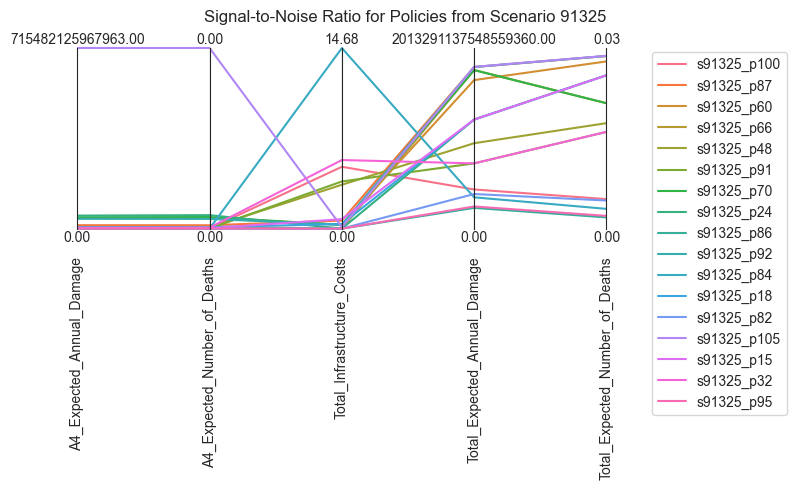

In [12]:
for scenario in scenarios:
        
    data = snr_scores[scenario]

    colors = sns.color_palette("husl", data.shape[0])
    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])

    paraxes.legend()
    plt.title(f'Signal-to-Noise Ratio for Policies from Scenario {scenario}', loc='right')
    plt.savefig('img/snr__all_' + scenario + '_pairplot.png')
    plt.show()

Above graphs allow to see how many policies there are per scenario, and compare them within scenario as well as between scenarios. 

The plot for scenario 54840 provides most insights on trade-offs due to a variety of SNR metric values across outcomes. 
We can observe that with higher *Total Infrastructure Costs*, one can reach lowest *Totals* (damages and dealths), while the damages and dealths in Dike Ring 4 are not so sensitive to changes in the *Total Infrastructure Costs*.
Consequently, when *Total Infrastructure Costs* are minimized this increases *Totals* (damages and dealths), but there exist policies able to keep the the damages and dealths in Dike Ring 4 close to zero.

SNR metric in this case is not greatly helpful in confidently selecting a small but diverse subset of robust candidate policies by visual inspection. We decide to filter down the 50 policies to 25 top performers in terms of *A4 Expected Annual Damage* SNR score, since this is the main outcome of concern for the client.

### Helper dataframes

In this section we prepare:
1. a single dataframe for robustness scores for easier further processing, initially filled with SNR scores (*all_data*)
2. a dataframe mapping policy to the non-zero levers used (*all_levers*)

In [13]:
# Create a helper df containing all policies and the policy levers they activate
list(experiments.columns)
lever_start = experiments.columns.get_loc('EWS_DaysToThreat')
lever_end = experiments.columns.get_loc('A5_DikeIncrease_t2')
policy_levers = experiments.iloc[: , lever_start:lever_end]
policy_levers['policy'] = experiments['policy']
policy_levers.head(3)

,EWS_DaysToThreat,rfr_0_t0,rfr_0_t1,rfr_0_t2,rfr_1_t0,rfr_1_t1,rfr_1_t2,rfr_2_t0,rfr_2_t1,rfr_2_t2,...,A2_DikeIncrease_t2,A3_DikeIncrease_t0,A3_DikeIncrease_t1,A3_DikeIncrease_t2,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A4_DikeIncrease_t2,A5_DikeIncrease_t0,A5_DikeIncrease_t1,policy
0,3,0,0,0,0,0,0,1,0,0,...,0,3,0,0,9,0,0,0,0,s91325_p100
1,3,0,0,0,0,0,0,1,0,0,...,0,3,0,0,9,0,0,0,0,s91325_p100
2,3,0,0,0,0,0,0,1,0,0,...,0,3,0,0,9,0,0,0,0,s91325_p100


In [14]:
# Create a dataframe storing SNR results per policy
all_data = pd.DataFrame()

for count, scenario in enumerate(scenarios):
    data = snr_scores[scenario]
    data['scenario'] = count
    all_data = pd.concat([all_data, data])

all_data.head(3)

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths,scenario
s54840_p74,4.526318e+13,1.232083e-07,0.315831,1.564667e+18,0.025815,0
s54840_p29,8.224101e+12,2.372459e-08,0.000000,9.272904e+17,0.022542,0
s54840_p66,4.230448e+12,1.373347e-08,4.593787,5.097826e+17,0.009232,0


In [15]:
# Create a helper df
candidate_policies = all_data.reset_index()
candidate_policies = candidate_policies.iloc[:,0]
candidate_policies = candidate_policies.tolist()

In [16]:
# Create sorted df, with all levers that are used at least once as columns, and all policies as rows
all_levers = pd.DataFrame()

for policy in candidate_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    df = df.iloc[[0]]
    nonzero_columns = (df != 0).all()
    df = df.loc[:, nonzero_columns]
    all_levers = pd.concat([all_levers, df])

all_levers = all_levers.reindex(sorted(all_levers.columns), axis=1)
all_levers.set_index('policy', inplace=True)
all_levers.head()

,A1_DikeIncrease_t0,A1_DikeIncrease_t1,A1_DikeIncrease_t2,A2_DikeIncrease_t0,A2_DikeIncrease_t1,A3_DikeIncrease_t0,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A5_DikeIncrease_t0,EWS_DaysToThreat,rfr_2_t0,rfr_2_t1,rfr_2_t2
policy,,,,,,,,,,,,,
s54840_p74,1.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4,NaN,NaN,NaN
s54840_p29,3.0,NaN,NaN,2.0,NaN,NaN,6.0,NaN,NaN,3,NaN,NaN,NaN
s54840_p66,3.0,NaN,NaN,3.0,NaN,2.0,7.0,NaN,2.0,4,NaN,NaN,NaN
s54840_p97,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4,NaN,1.0,NaN
s54840_p67,3.0,NaN,NaN,5.0,NaN,NaN,8.0,NaN,3.0,4,NaN,NaN,NaN


### Selecting 50% most robust policies (SNR)

In [17]:
# Apply the filtering
all_data = all_data.drop(all_data['A4_Expected_Annual_Damage'].nlargest(25).index)

In [18]:
# Determine min and max values for plotting
limits = parcoords.get_limits(all_data)
limits.loc[0, outcomes_of_interest]  = 0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = all_data[outcome].max()
limits = limits.drop(columns=['scenario'])
limits

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.00000
1,8.224101e+12,2.372459e-08,14.679912,1.932468e+18,0.02768


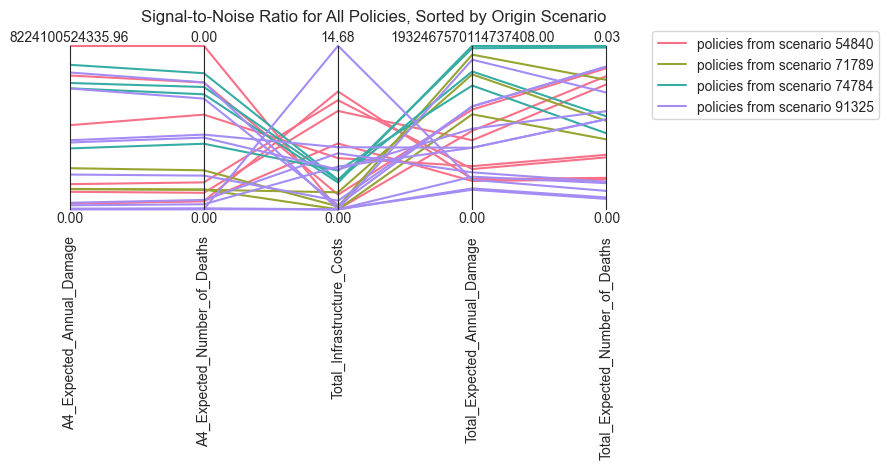

In [19]:
colors = sns.color_palette("husl", len(scenarios))
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for count, scenario in enumerate(scenarios):

    data = all_data[all_data['scenario'] == count]
    paraxes.plot(data, color=colors[count], label='policies from scenario ' + original_scenarios[count])
        
    plt.title(f'Signal-to-Noise Ratio for All Policies, Sorted by Origin Scenario', loc='right')
    plt.savefig('img/snr__top50_grouped_pairplot.png')
    
paraxes.legend()

While the plot is still cluttered, we will visualise these results per scenario.

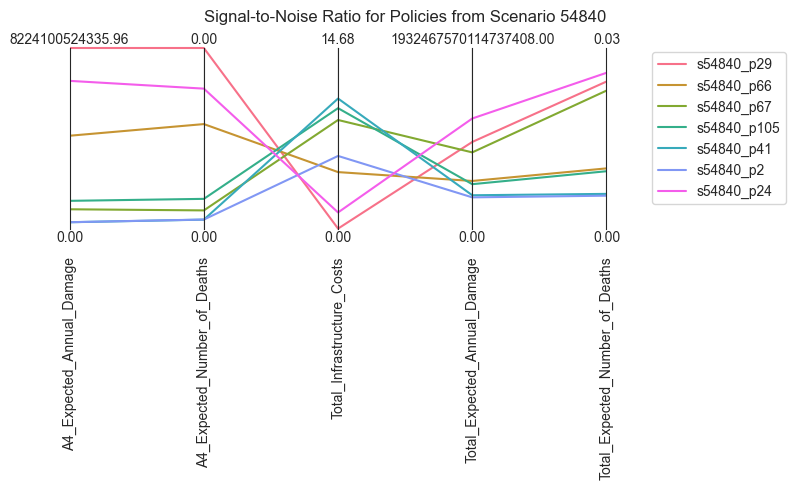

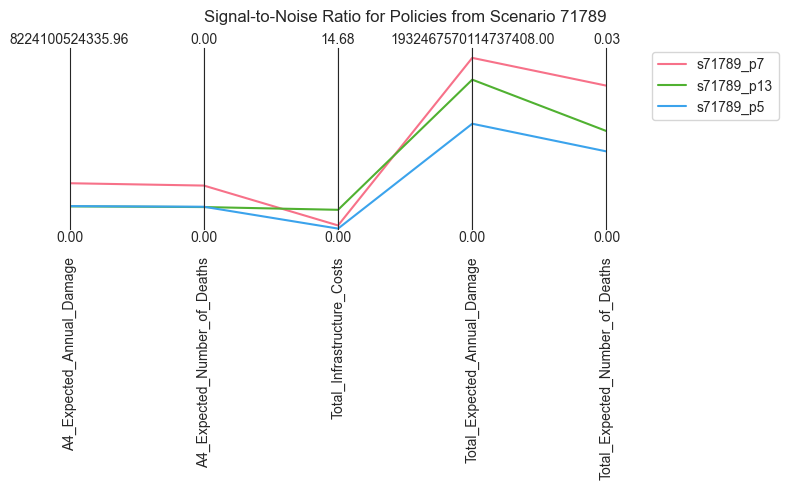

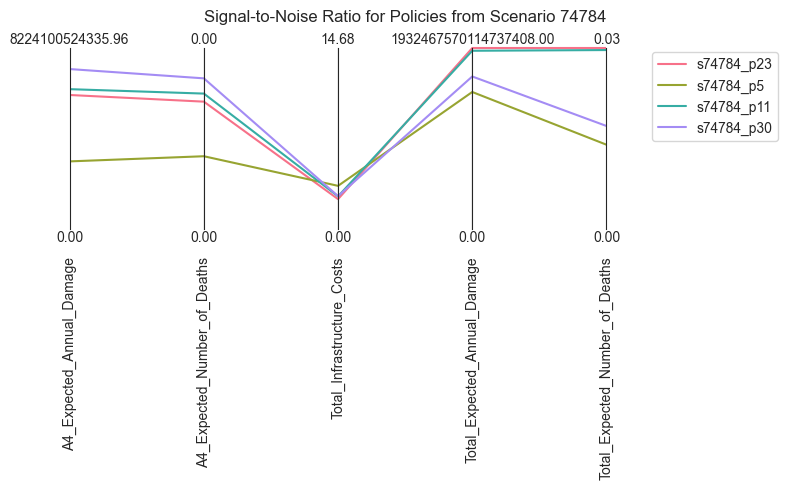

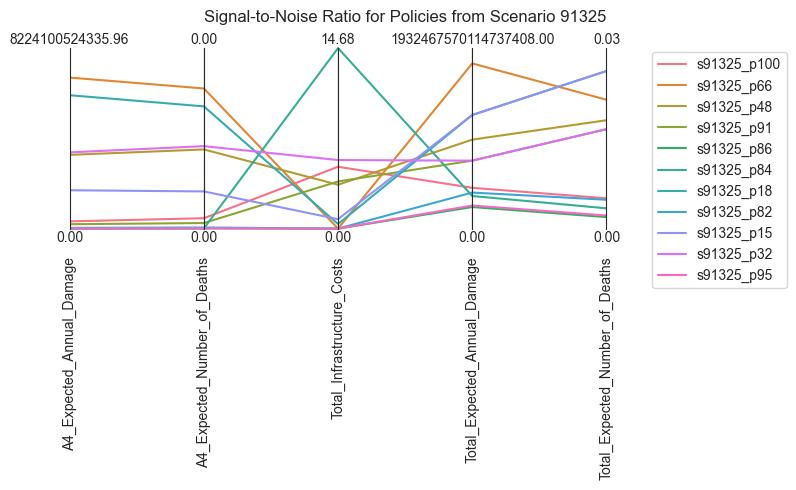

In [20]:
for count, scenario in enumerate(scenarios):
        
    data = all_data[all_data['scenario'] == count]

    colors = sns.color_palette("husl", data.shape[0])
    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Signal-to-Noise Ratio for Policies from Scenario {scenario}', loc='right')
    plt.savefig('img/snr__top50_' + scenario + '_pairplot.png')
    plt.show()

After inspecting the visualizations above, the following conclusions were drawn :

*Note that we are only looking within origin scenarios to easily (and visually) identify dominance within a smaller selection of the candidate policy set.*

In terms of SNR:

- In scenario s54840 policy 2 dominates 67, 41, 105.
- In scenario s71789 policy 5 dominates 7 and 13.
- In scenario s74784 policy 5 performs very well across the board compared to others within its scenario, though having a higher infra cost. The others have mildly interesting trade-offs but are much worse.
- In scenario s91325 policy 86 practically dominates everything, but barely dominates 95.

#### Comment on the remaining policies

Here, we prepare a dataframe of remaining policies and print it to inspect the levers visually.

In [21]:
# Create a list of all remaining policies after initial filtering
remaining_policies = all_data.reset_index()
remaining_policies = remaining_policies.iloc[:,0]
remaining_policies = remaining_policies.tolist()

In [22]:
# Create a df with all columns with non-zero values and rows as policies
remaining_levers = pd.DataFrame()

for policy in remaining_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    df = df.iloc[[0]]
    nonzero_columns = (df != 0).all()
    df = df.loc[:, nonzero_columns]
    remaining_levers = pd.concat([remaining_levers, df])

remaining_levers = remaining_levers.reindex(sorted(remaining_levers.columns), axis=1)
remaining_levers.set_index('policy', inplace=True)

In [23]:
remaining_levers

,A1_DikeIncrease_t0,A2_DikeIncrease_t0,A2_DikeIncrease_t1,A3_DikeIncrease_t0,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A5_DikeIncrease_t0,EWS_DaysToThreat,rfr_2_t0,rfr_2_t1,rfr_2_t2
policy,,,,,,,,,,,
s54840_p29,3.0,2.0,NaN,NaN,6,NaN,NaN,3,NaN,NaN,NaN
s54840_p66,3.0,3.0,NaN,2.0,7,NaN,2.0,4,NaN,NaN,NaN
s54840_p67,3.0,5.0,NaN,NaN,8,NaN,3.0,4,NaN,NaN,NaN
s54840_p105,3.0,4.0,NaN,2.0,8,NaN,3.0,3,NaN,NaN,NaN
s54840_p41,3.0,5.0,NaN,3.0,9,NaN,4.0,3,NaN,NaN,NaN
s54840_p2,3.0,7.0,NaN,3.0,9,NaN,6.0,3,NaN,NaN,NaN
s54840_p24,2.0,1.0,NaN,NaN,6,NaN,NaN,4,NaN,NaN,NaN
s71789_p7,NaN,NaN,NaN,1.0,7,NaN,NaN,3,NaN,NaN,NaN
s71789_p13,NaN,NaN,NaN,NaN,8,NaN,1.0,3,1.0,NaN,1.0


In the DataFrame above, the policy levers that were activated to create each of the remaining 25 candidate policies can be seen. Due to a smaller number of policies we can already inspect what levers they include.

In terms of policy lever diversity:
- In scenario s54840: no RfR, always a strategy with much overall dike heightening
- In scenario s71789 13 and 5 polcies have RfR projects, 7, 13 and 5 little other dike support.
- In scenario s74784: policy 30 has RfR and little other dike support.
- In scenario s91325: policies 100, 66, 86 and 84 have RfR projects. Policies 66, 18, 15 offer little other dike support. Policies 86, 84 and 95 see further A4 dike raising at t1.
- Notably, EWS_DaysToThread which means to days of evacuation before flood is set to 3-4 across the board.
- Notably, A4 dike increase at t0 is 60cm or higher aross the board.

---------------------

## 2. Maximum Regret


In [24]:
# Function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

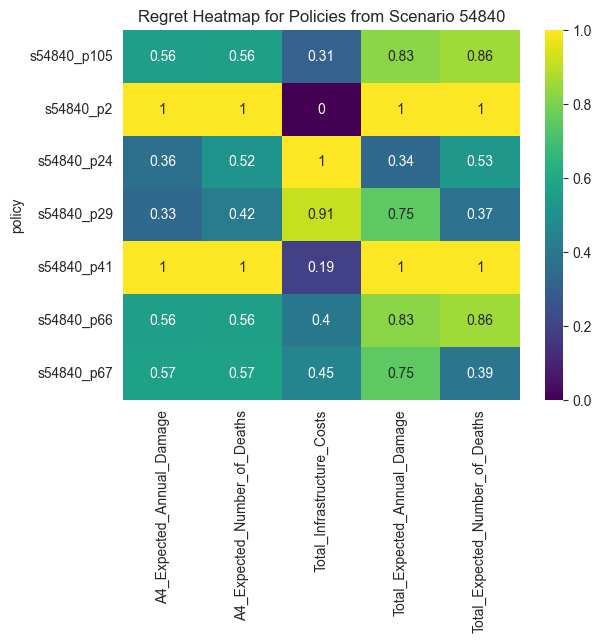

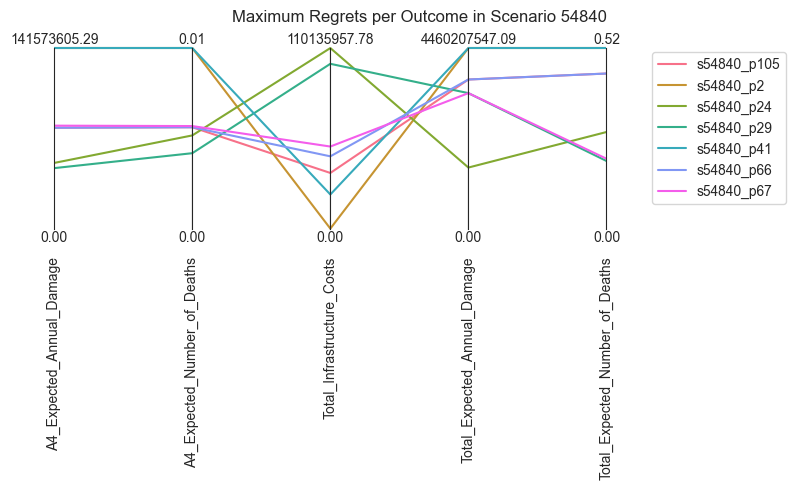

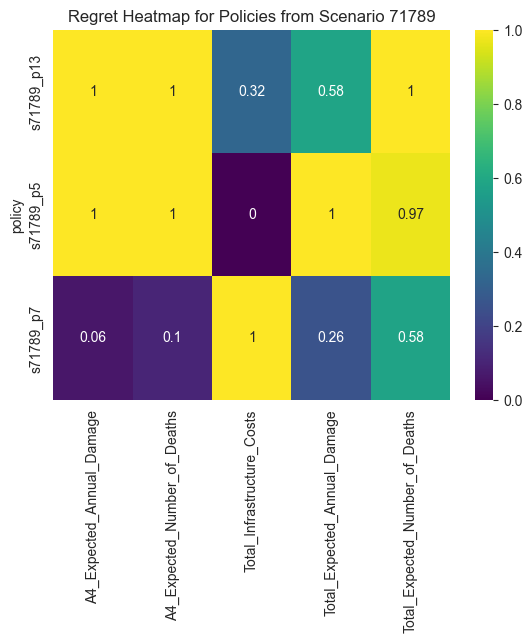

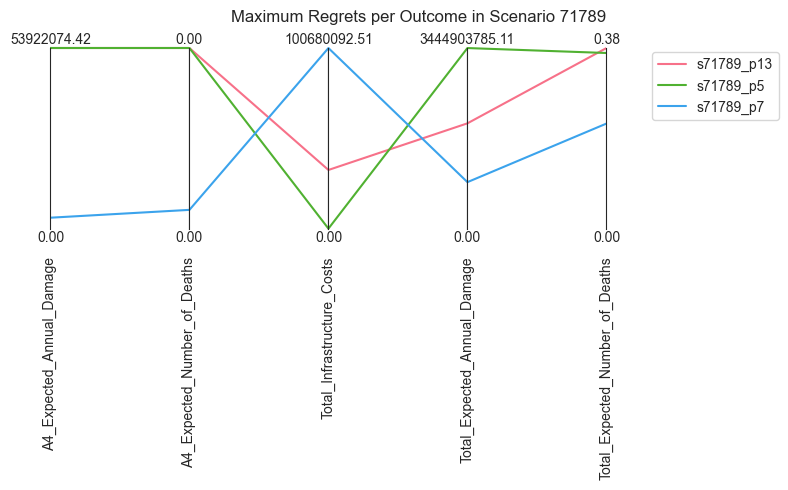

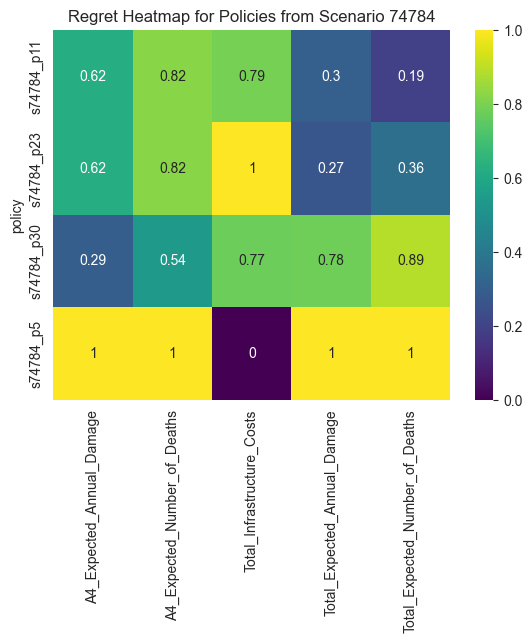

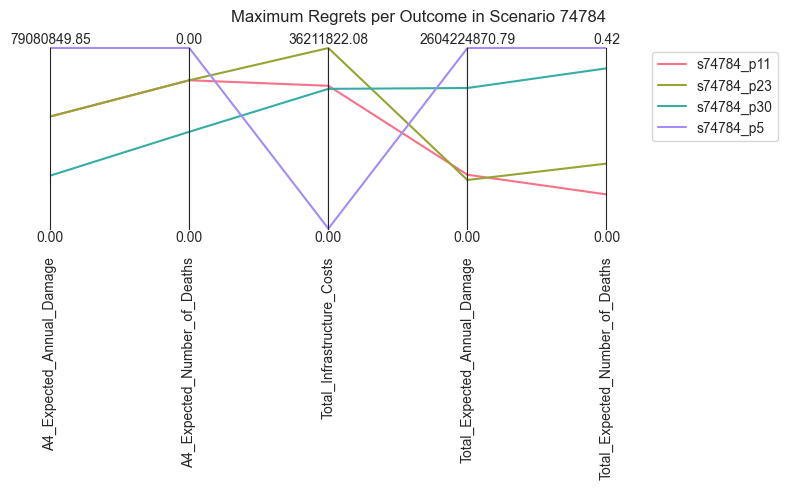

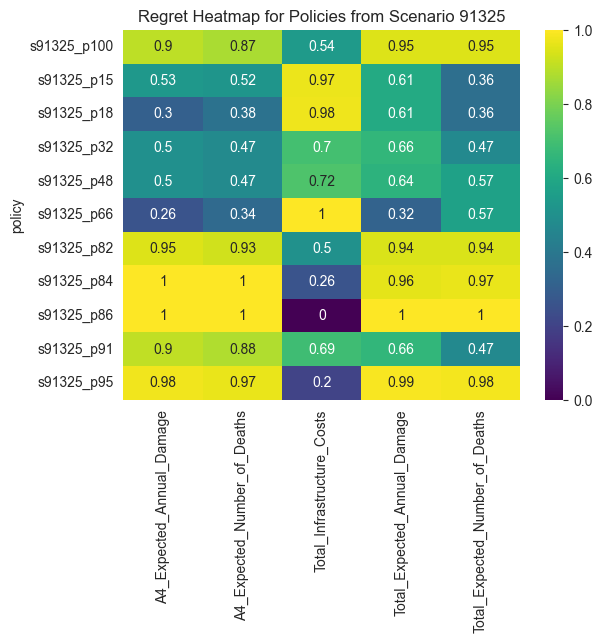

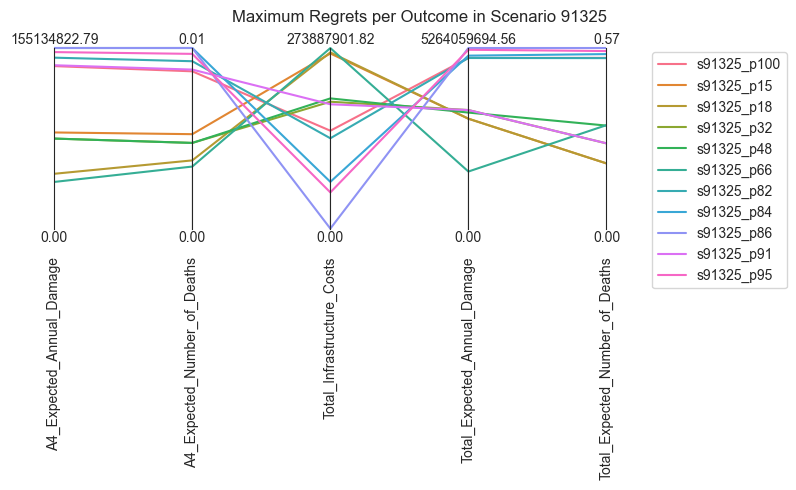

In [25]:
# Generate of a dataframe and plots of maximum regret metric per each scenario separately
for scenario in scenarios:
    
    all_regrets = {}
    max_regret = {}
    
    for outcome in model.outcomes:
        experiments_df = experiments_by_scenario[scenario]
        outcomes_dict = outcomes_by_scenario[scenario]
        # Create a DataFrame with all the relevent information
        # i.e., policy, scenario_id, and scores
        data = pd.DataFrame({
            outcome.name : outcomes_dict[outcome.name], 
            "policy" : experiments_df['policy'],
            "robustness_scenario" : experiments_df['scenario'],
        })
        
        # Filter out rows that are not for policies kept according to signal to noise ratio. 
        data = data[data['policy'].isin(remaining_policies)]

        # Reorient the data by indexing with policy and scenario id
        data = data.pivot(index='robustness_scenario', columns='policy')

        data.columns = data.columns.get_level_values(1)
        outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
        
        all_regrets[outcome.name] = outcome_regret
        max_regret[outcome.name] = outcome_regret.max()

    # Plot regret heatmap
    max_regret = pd.DataFrame(max_regret)
    sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
    plt.title(f'Regret Heatmap for Policies from Scenario {scenario}')
    plt.savefig('img/regret__top50_' + scenario + '_heatmap.png')
    plt.show()

    # Plot regret pairplot
    data = max_regret

    limits = parcoords.get_limits(data)
    limits.loc[0, outcomes_of_interest] = 0

    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        colors = sns.color_palette("husl", data.shape[0])
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Maximum Regrets per Outcome in Scenario {scenario}', loc='right')
    plt.savefig('img/regret__top50_' + scenario + '_pairplot.png')
        
    plt.show()

After inspecting the visualizations above, the following conclusions were drawn :

*Note that we are only looking within origin scenarios to easily (and visually) identify dominance within a smaller selection of the candidate policy set.*

In terms of Max regret:

- In scenario s54840 no policy is dominant. The largest trade-off is clearly visible in *Total Infrastructure Costs*, which is balanced by all other outcomes combined. Policies that perform well on infra costs, perform poorly elsewhere and vice-versa. However, 66 and 67 policies thread the needle, performing decently on all outcomes but not stellar anywhere.
- In scenario s71789 three policies have with diverse trade-offs. Note that policy 5 performs well in SNR, but only performs well in terms of *Total Infrastructure Costs* for the Max Regret metric.
- In scenario s74784 policy 11 beats out policy 23 for our purposes. A minor increased in expected overall damages is offset by fewer deaths and far lower *Total Infrastructure Costs*.
- In scenario s91325 policy 18 and policy 14 are dominated. Policy 32 and policy 48 perform very similarly. Likewise policy 82 and policy 100 perform similarly.

## 3. Final analysis and selection

#### 3.1 Analytical filtering
Combining aforementioned insights into SNR and Max Regret robustness and levers diversity of policies, we **drop following policies from further analysis**:
 - for scenario s54840:
    - policy 67, as it's similar to policy 66 in terms of Max Regret and dominated by policy 2 in terms of SNR.
    - policy 41, as it is dominated and otherwise uninteresting in terms of levers or max Regret.
 - for scenario s71789:
    - policy 7, as policy 13 is kept for similarly interesting policy levers, but are both not great performers.
 - for scenario s74784:
    - policy 23, no interesting levers and otherwise outperformed.
 - for scenario s91325:
    - policy 15, dominated in SNR, uninteresting.
    - policy 18, dominated, uninteresting.
    - policy 32, performs similarly to policy 48.
    - policy 84, similar to other policies.
    - policy 82, dominated by policy 2 from scenario 54840.

In [26]:
# Filter the df of policies remaining
drop_list = ['s54840_p67', 's54840_p41', 's71789_p7', 's74784_p23', 's91325_p15', 's91325_p18', 's91325_p32', 's91325_p84',
            's91325_p82']
for policy in drop_list:
    all_data = all_data.drop([policy])

remaining_policies = all_data.reset_index()
remaining_policies = remaining_policies.iloc[:,0]
remaining_policies = remaining_policies.tolist()

for policy in remaining_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    df = df.iloc[[0]]
    nonzero_columns = (df != 0).all()
    df = df.loc[:, nonzero_columns]
    remaining_levers = pd.concat([remaining_levers, df])

remaining_levers = remaining_levers.reindex(sorted(remaining_levers.columns), axis=1)
remaining_levers.set_index('policy', inplace=True)

Next we plot SNR and Maximum Regret, which we recalculate taking into account only remaining policies. This choice is a limitaion.

#### 3.2 SNR plotting

In [27]:
# Determine min and max values for plotting
limits = parcoords.get_limits(all_data)
limits.loc[0, outcomes_of_interest]  = 0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = all_data[outcome].max()
limits = limits.drop(columns=['scenario'])

In [28]:
# Sort rows to match the order of Max Regret
all_data = all_data.sort_index()

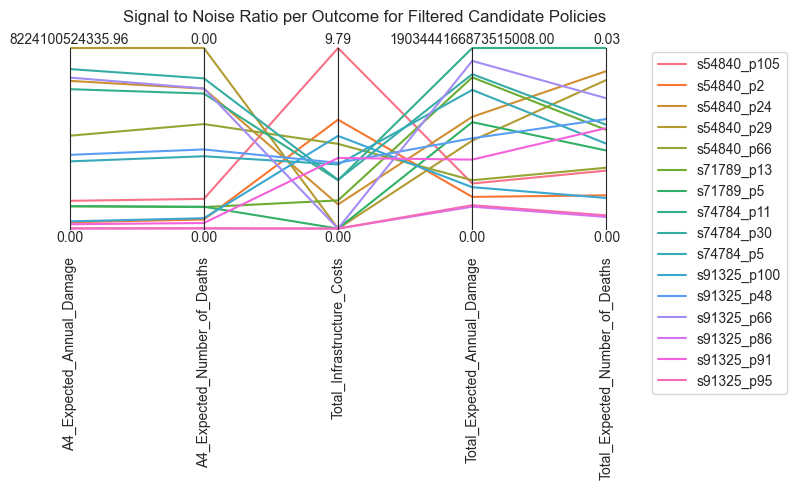

In [29]:
# Plot SNR pairplot
colors = sns.color_palette("husl", all_data.shape[0])
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(all_data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()
plt.title(f'Signal to Noise Ratio per Outcome for Filtered Candidate Policies', loc='right')
plt.savefig('img/snr__filtered_pairplot.png')

#### 3.3 Max Regret plotting

In [30]:
# Prepare new Max Regret data
all_regrets = {}
max_regret = {}

for outcome in model.outcomes:
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data[data['policy'].isin(remaining_policies)]
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    all_regrets[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

max_regret = pd.DataFrame(max_regret)
data = max_regret
data = data.sort_index()

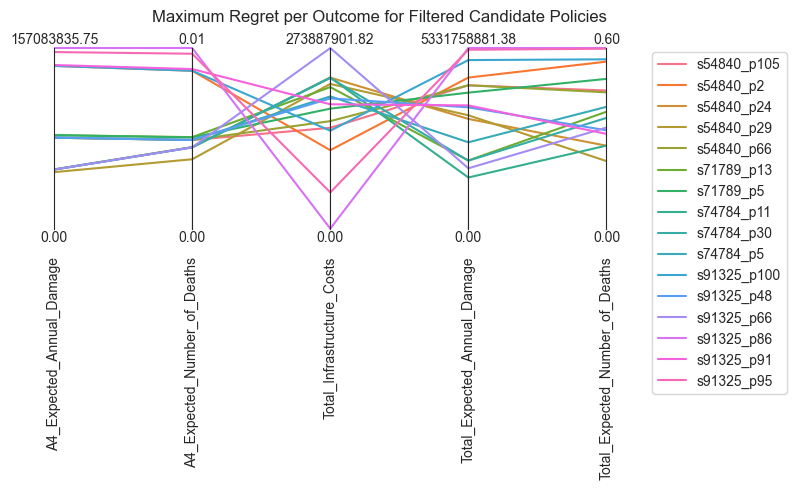

In [31]:
# Plot Max Regret pairplot
limits = parcoords.get_limits(data)
limits.loc[0, outcomes_of_interest] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    colors = sns.color_palette("husl", data.shape[0])
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()
plt.title(f'Maximum Regret per Outcome for Filtered Candidate Policies', loc='right')
plt.savefig('img/regret__filtered_pairplot.png')

Considering the two last plots we can make the final selection of policies.
#### 3.4 Final selection

The two top performers overall, while being internally diverse in terms of policy levers are:
- s91325_p95
- s91325_p86

Strong performer that has solid robustness across all metrics taking a middle approach:
- s54840_p2

Alternative strategy focusing only on mild dike raising for and RfR projects:
- s91324_p100

Note that the first two options are clear winners in terms of SNR, indicating consistent policies that provide safety through large initial investments in dike raising across the board. Notably, s91325_p86 employs RfR_2, while s91325_p95 relies solely on dikes. 

The third option offers a sub-optimal solution in all cases, but proves to be safer and more robust in a wide range of uncertainty parameters. This too is a dike-based strategy. 

The final option performs the worst across the board in terms of the quantitative outcomes of the model. However, it is an attractive option where the focus lies on nature preservation and less reliance on dikes.

In [32]:
# Filter the selected policies
final_policies = ['s91325_p86', 's91325_p95', 's54840_p2', 's91325_p100']
all_data = all_data.loc[final_policies]
remaining_levers = remaining_levers.loc[final_policies]
remaining_policies = all_data.reset_index()
remaining_policies = remaining_policies.iloc[:,0]
remaining_policies = remaining_policies.tolist()

In [33]:
remaining_levers

,A1_DikeIncrease_t0,A2_DikeIncrease_t0,A2_DikeIncrease_t1,A3_DikeIncrease_t0,A4_DikeIncrease_t0,A4_DikeIncrease_t1,A5_DikeIncrease_t0,EWS_DaysToThreat,rfr_2_t0,rfr_2_t1,rfr_2_t2
policy,,,,,,,,,,,
s91325_p86,3.0,5.0,2.0,4.0,10,7.0,5.0,3,NaN,1.0,1.0
s91325_p95,3.0,6.0,3.0,6.0,10,2.0,4.0,3,NaN,NaN,NaN
s54840_p2,3.0,7.0,NaN,3.0,9,NaN,6.0,3,NaN,NaN,NaN
s91325_p100,3.0,4.0,NaN,3.0,9,NaN,NaN,3,1.0,NaN,NaN


What remains is to produce a pairplots of mean outcomes for the selected policies.

In [34]:
# Calculate mean outcome and put into a df
mean_scores = {}
for policy in final_policies:
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        mean = np.mean(value)
        scores[outcome.name] = mean
    mean_scores[policy] = scores
mean_scores_df = pd.DataFrame.from_dict(mean_scores).T

In [35]:
mean_scores_df

,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
s91325_p86,20307.188062,0.000001,3.171744e+08,3.086575e+08,0.028369
s91325_p95,27296.390988,0.000002,2.622857e+08,3.295294e+08,0.031349
s54840_p2,139750.378358,0.000009,1.982227e+08,4.162977e+08,0.053393
s91325_p100,155256.146703,0.000010,1.686922e+08,5.798562e+08,0.063612


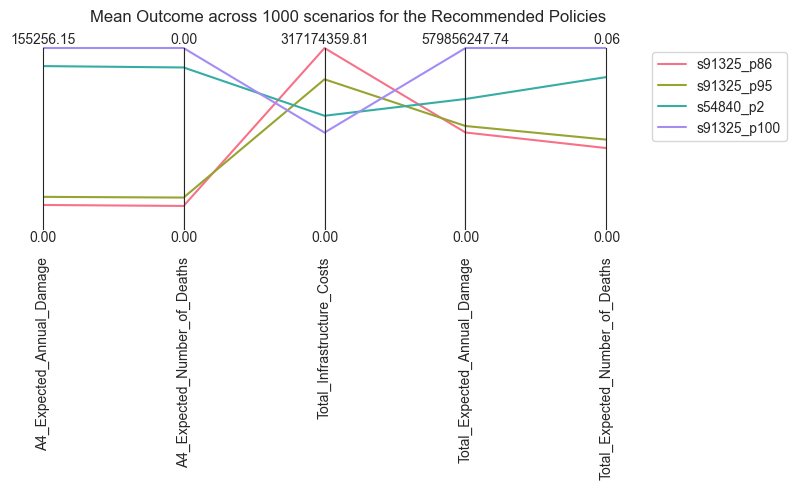

In [36]:
# Plot mean outcomes per 4 selected policies
limits = parcoords.get_limits(mean_scores_df)
limits.loc[0, outcomes_of_interest]  = 0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = mean_scores_df[outcome].max()

colors = sns.color_palette("husl", mean_scores_df.shape[0])
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(mean_scores_df.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()
plt.title(f'Mean Outcome across 1000 scenarios for the Recommended Policies', loc='right')
plt.savefig('img/mean__final4_pairplot.png')

Based on the above pairplot, we can see clearly the trade-off between investment costs and flood impacts (damages and deaths). Two of the proposed policies minimize costs, while the other two minimize the impact, brdnging the impacts down more significantly for Dike Ring 4 than overall.